# Seminar 2

In this seminar we train different VAD models.

Dataset: https://disk.yandex.ru/d/LJlkc_WMo-libA

In [124]:
import os

import numpy as np
import matplotlib.pyplot as plt
import requests
from sklearn.linear_model import LogisticRegression
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchaudio
import urllib
from tqdm import tqdm

import IPython

### Download data

In [9]:
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
public_key = 'https://disk.yandex.ru/d/LJlkc_WMo-libA'
final_url = base_url + urllib.parse.urlencode(dict(public_key=public_key))
response = requests.get(final_url)
download_url = response.json()['href']
!wget -O data_sem.tar.gz "{download_url}"
!tar -xf data_sem.tar.gz


--2024-10-14 20:52:15--  https://downloader.disk.yandex.ru/disk/616d8e4c09a2d4eb87e0c598abe617fa80c4960e5e6e65d22f3985d296ed8e6a/670d928f/gtj3WQiuHGabqHv6W0pVHOyU6CN1oLeAGkDn-ZPe-6Z75o5sV1YhDnlc8TB5qaMgrsRNF3AQ5jVmqM_7KWldtg%3D%3D?uid=0&filename=vad.tar.gz&disposition=attachment&hash=xNl9zyY4MVv885ADo3YdxK0cjYUJpvBOFDMBce1v/nqkkt6F5riqtEefvUDL1r5nq/J6bpmRyOJonT3VoXnDag%3D%3D%3A&limit=0&content_type=application%2Fx-gzip&owner_uid=163052607&fsize=24567283&hid=d194eddc3de0a89d9208c5e452965d10&media_type=compressed&tknv=v2
Resolving downloader.disk.yandex.ru (downloader.disk.yandex.ru)... 77.88.21.127
Connecting to downloader.disk.yandex.ru (downloader.disk.yandex.ru)|77.88.21.127|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://s1047sas.storage.yandex.net/rdisk/616d8e4c09a2d4eb87e0c598abe617fa80c4960e5e6e65d22f3985d296ed8e6a/670d928f/gtj3WQiuHGabqHv6W0pVHOyU6CN1oLeAGkDn-ZPe-6Z75o5sV1YhDnlc8TB5qaMgrsRNF3AQ5jVmqM_7KWldtg==?uid=0&filename=vad.tar.gz&disp

In [10]:
DATADIR = 'data'
WAVDIR = os.path.join(DATADIR, 'wav')
ALIGNDIR = os.path.join(DATADIR, 'align')
FS = 16000
FRAME = 30 * FS // 1000
TRAIN = 350
DEVICE = 'mps'

In [11]:
class Dataset:
    def __init__(self):
        uttids = [uttid.split('.')[0] for uttid in os.listdir(WAVDIR)]
        self._data = []
        for uttid in uttids:
            wav_path = os.path.join(WAVDIR, f'{uttid}.wav')
            wav, fs = torchaudio.load(wav_path)
            assert fs == FS
            align = np.load(os.path.join(ALIGNDIR, f'{uttid}.npy'))
            while align.shape[0] * FRAME > wav.shape[1]:
                align = align[:-1]
            self._data.append((wav[:, :align.shape[0] * FRAME], align, wav_path))

    def __getitem__(self, idx: int):
        return self._data[idx]
    
    def __len__(self):
        return len(self._data)
    
dataset = Dataset()

### Sample

Let's take a look at audiofile, its waveform and its align targets: 

In [12]:
IPython.display.Audio(dataset[0][2])

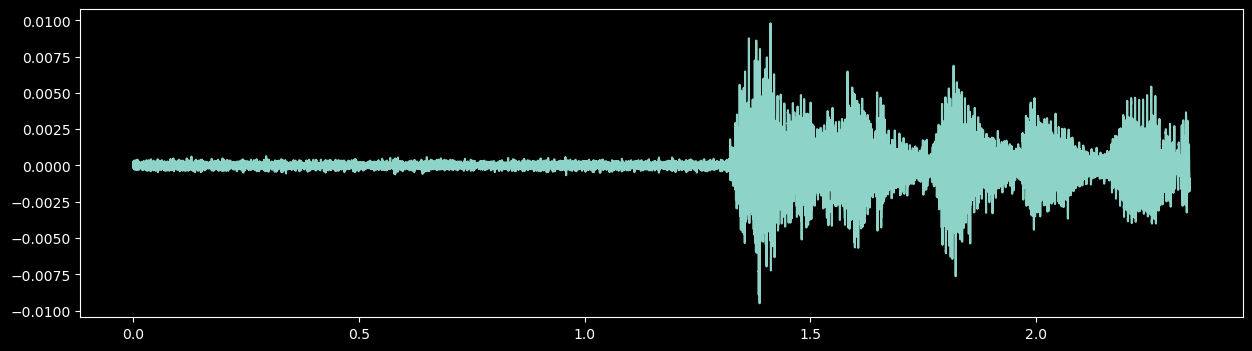

In [13]:
plt.figure(figsize=(15, 4))
plt.plot(np.arange(0, dataset[0][0].shape[1] / FS, 1 / FS), dataset[0][0][0])
plt.show()

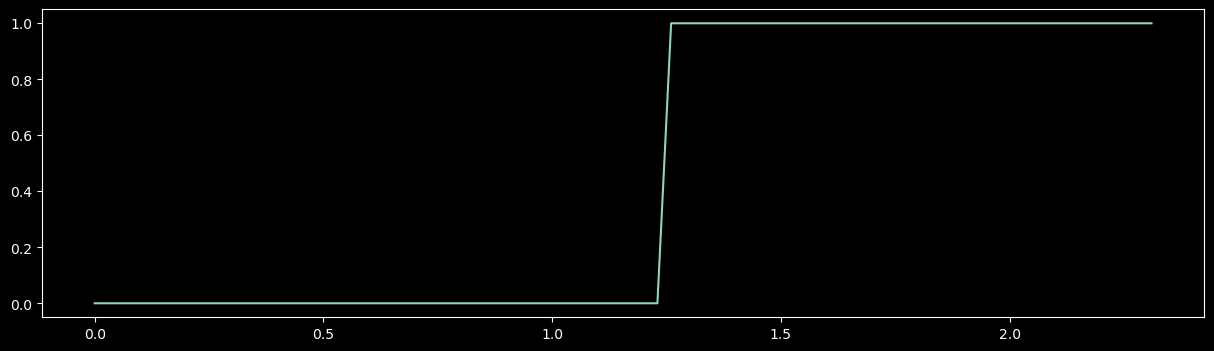

In [14]:
plt.figure(figsize=(15, 4))
plt.plot(np.arange(0, dataset[0][1].shape[0] * 0.03 - 1e-6, 0.03), dataset[0][1])
plt.show()

### Score and Tuning

A large number of metrics can be used for the vad task. Let's try to implement the following:
- Per-frame Accuracy $\frac{\sum_i^N \sum_j^{A_i} I(A_{ij} = P_{ij})}{\sum_i^N \sum_j^{A_i} 1}$
- Per-frame Accuracy with utterance normalization $\frac{1}{N} \sum_i^N \frac{\sum_j^{A_i} I(A_{ij} = P_{ij})}{\sum_j^{A_i} 1}$
- Intersection-over-Union $\frac{1}{N} \sum_i^N \frac{\sum_j^{A_i} I(A_{ij} = P_{ij} = 1)}{\sum_j^{A_i} I(A_{ij} = 1 || P_{ij} = 1)}$

where:
- $N$ -- number of utterances
- $A_{ij}$ -- target for $j$-th frame of $i$-th utterance
- $P_{ij}$ -- predict for $j$-th frame of $i$-th utterance

In [15]:
def score(probs: list[np.ndarray], aligns: list[np.ndarray], thr: float = 0.5):
    preds = [prob > thr for prob in probs]
    acc1 = np.mean(np.concatenate(preds) == np.concatenate(aligns))
    acc2 = np.mean(
        [np.mean(pred == align) for pred, align in zip(preds, aligns)]
    )
    iou = np.mean(
        [
            np.sum(np.logical_and(pred, align))
            / np.sum(np.logical_or(pred, align))
            for pred, align in zip(preds, aligns)
        ]
    )
    return (
        f"Per-frame acc: {acc1}, Per-frame in utterance acc {acc2}, IoU: {iou}"
    )

In [16]:
score([np.array([0.6]), np.array([0.4, 0.7])], [np.array([1]), np.array([0, 1])])

'Per-frame acc: 1.0, Per-frame in utterance acc 1.0, IoU: 1.0'

Let's write function to find optimal thresholds for per-frame Accuracy metric:

In [17]:
def per_frame_accuracy(probs: list[np.ndarray], aligns: list[np.ndarray], thr: float = 0.5):
    preds = [prob > thr for prob in probs]
    acc = np.mean(np.concatenate(preds) == np.concatenate(aligns))
    return acc

In [18]:
def optimal_thresold(probs, aligns):
    thresholds = np.unique(np.concatenate(probs))
    best_acc = 0
    best_thr = 0
    
    for thr in thresholds:
        acc = per_frame_accuracy(probs, aligns, thr)
        if acc > best_acc:
            best_acc = acc
            best_thr = thr
    
    return best_thr, best_acc

In [19]:
optimal_thresold([np.array([0.6]), np.array([0.4, 0.7])], [np.array([0]), np.array([0, 1])])

(0.6, 1.0)

### Energy VAD

Energy for one frame can be calculated as follows:
$$\frac{1}{N} \sum_i^N x_i^2$$
Where $N$ -- number of amplitudes in frame, $x_i$ -- $i$-th amplitude value.

We can get rid of $\frac{1}{N}$ in this formula, if all frames has the same size.

In [20]:
Y = np.concatenate([item[1] for item in dataset[:TRAIN]])
X = np.array(np.split(np.concatenate([item[0][0] for item in dataset[:TRAIN]]), Y.shape[0]))
Y_test = np.concatenate([item[1] for item in dataset[TRAIN:]])
X_test = np.array(np.split(np.concatenate([item[0][0] for item in dataset[TRAIN:]]), Y_test.shape[0]))
parts = np.cumsum([item[1].shape[0] for item in dataset[TRAIN:]])[:-1]
train_preds = np.mean(X * X, axis=1)
thr, train_acc = optimal_thresold([train_preds], [Y])
test_preds = np.mean(X_test * X_test, axis=1)
test_score = score(np.split(test_preds, parts), np.split(Y_test, parts), thr)
print(train_acc, test_score)

0.9011240795864014 Per-frame acc: 0.9042538702501476, Per-frame in utterance acc 0.8935556547197742, IoU: 0.6726715866328522


### Linear VAD

Let's try to use simple binary classification model for each frame.

In [21]:
def frame_classification(transform: nn.Module):
    X = np.concatenate([transform(item[0])[0].T.data.numpy()[:-1, :] for item in dataset[:TRAIN]])
    Y = np.concatenate([item[1] for item in dataset[:TRAIN]])
    X_test = np.concatenate([transform(item[0])[0].T.data.numpy()[:-1, :] for item in dataset[TRAIN:]])
    Y_test = np.concatenate([item[1] for item in dataset[TRAIN:]])
    parts = np.cumsum([item[1].shape[0] for item in dataset[TRAIN:]])[:-1]
    model = LogisticRegression(max_iter=1000)
    model.fit(X, Y)
    train_preds = model.predict_proba(X)[:, 1]
    test_preds = model.predict_proba(X_test)[:, 1]
    thr, train_acc = optimal_thresold([train_preds], [Y])
    test_score = score(np.split(test_preds, parts), np.split(Y_test, parts), thr)
    print(train_acc, test_score)

In [22]:
frame_classification(torchaudio.transforms.MelSpectrogram(n_fft=FRAME, hop_length=FRAME, n_mels=23))

0.9029257402475325 Per-frame acc: 0.9037544831343352, Per-frame in utterance acc 0.8928250512833915, IoU: 0.6605857590582279


In [23]:
frame_classification(
    torchaudio.transforms.MFCC(n_mfcc=13, melkwargs={'n_mels': 23, 'n_fft': FRAME, 'hop_length': FRAME})
)

0.9148911170296099 Per-frame acc: 0.90684160348663, Per-frame in utterance acc 0.8965163243440217, IoU: 0.6874882405786664


In [24]:
class LogMelSpectrogram(nn.Module):
    def __init__(self, n_fft: int, hop_length: int, n_mels: int):
        super().__init__()
        self.mel = torchaudio.transforms.MelSpectrogram(n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)
    
    def forward(self, x):
        x = self.mel(x)
        x = torch.log(x + 1e-8)
        return x
    
frame_classification(LogMelSpectrogram(n_fft=FRAME, hop_length=FRAME, n_mels=23))

0.9154981983393389 Per-frame acc: 0.90684160348663, Per-frame in utterance acc 0.8960845767418975, IoU: 0.6847386299177817


### NN VAD

Let's try to aggregate adjacent frames:

In [125]:
class VAD(nn.Module):
    def __init__(self, f_in, hidden):
        super().__init__()
        self.sequential = nn.Sequential(
            nn.Conv1d(f_in, hidden, 5, padding=2),
            nn.BatchNorm1d(hidden),
            nn.ReLU(),
            nn.Conv1d(hidden, 1, 1),
        )

    def forward(self, x):
        return self.sequential(x)

In [126]:
def train_one_epoch(
    model: nn.Module,
    optimizer: torch.optim.Optimizer,
    criterion: torch.nn.Module,
    X: torch.Tensor,
    Y: torch.Tensor,
    device,
):
    # for X, Y in dataloader:
    X.to(device)
    Y.to(device)

    output = model(X).squeeze()
    loss = criterion(output, Y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


def multiframe_classification(transform: nn.Module, model: nn.Module):
    X = [transform(item[0])[0][:, :-1] for item in dataset]
    y = [torch.tensor(item[1]) for item in dataset]
    max_time = max([item.shape[1] for item in X])
    print(max_time)

    train_lens = []
    X_train = torch.zeros((TRAIN, 13, max_time))
    y_train = torch.zeros(TRAIN, max_time)
    for i in range(TRAIN):
        X_train[i, :, : X[i].shape[1]] = X[i]
        y_train[i, : X[i].shape[1]] = y[i]
        train_lens += [X[i].shape[1]]

    test_lens = []
    X_test = torch.zeros((len(dataset) - TRAIN, 13, max_time))
    y_test = torch.zeros(len(dataset) - TRAIN, max_time)
    for i in range(TRAIN, len(dataset)):
        X_test[i - TRAIN, :, : X[i].shape[1]] = X[i]
        y_test[i - TRAIN, : X[i].shape[1]] = y[i]
        test_lens += [X[i].shape[1]]

    optimizer = torch.optim.AdamW(model.parameters(), lr=0.01)
    criterion = nn.BCEWithLogitsLoss()

    for epoch in tqdm(range(100)):
        train_one_epoch(
            model, optimizer, criterion, X_train, y_train, device=DEVICE
        )

    out = F.sigmoid(model(X_train).squeeze()).detach().cpu().numpy()
    train_probs = [out[i, : train_lens[i]] for i in range(TRAIN)]
    np_y = [
        y_train[i, : train_lens[i]].detach().cpu().numpy() for i in range(TRAIN)
    ]
    thr, train_acc = optimal_thresold(train_probs, np_y)

    out = F.sigmoid(model(X_test).squeeze()).detach().cpu().numpy()
    test_probs = [out[i, : test_lens[i]] for i in range(len(dataset) - TRAIN)]
    np_y = [
        y_test[i, : test_lens[i]].detach().cpu().numpy()
        for i in range(len(dataset) - TRAIN)
    ]

    test_score = score(
        test_probs,
        np_y,
        thr,
    )
    print(train_acc, test_score)

In [127]:
multiframe_classification(
    torchaudio.transforms.MelSpectrogram(
        n_fft=FRAME, hop_length=FRAME, n_mels=13
    ),
    VAD(13, 64),
)

330


100%|██████████| 100/100 [00:13<00:00,  7.34it/s]


0.9284623217922607 Per-frame acc: 0.9147409996822082, Per-frame in utterance acc 0.9088420442915882, IoU: 0.7846187351410676


In [129]:
multiframe_classification(
    torchaudio.transforms.MFCC(
        n_mfcc=13, melkwargs={"n_mels": 23, "n_fft": FRAME, "hop_length": FRAME}
    ),
    VAD(13, 64),
)

330


100%|██████████| 100/100 [00:14<00:00,  7.13it/s]


0.9427385242049193 Per-frame acc: 0.9288600354110864, Per-frame in utterance acc 0.9237597618953715, IoU: 0.7651603946545478


In [130]:
multiframe_classification(
    LogMelSpectrogram(n_fft=FRAME, hop_length=FRAME, n_mels=13), VAD(13, 64)
)

330


100%|██████████| 100/100 [00:13<00:00,  7.41it/s]


0.9398402005326649 Per-frame acc: 0.9285876424388251, Per-frame in utterance acc 0.9227809639666846, IoU: 0.76217559446056


### Check model errors

Let's try to get some previous model and use it to make prediction.
After that, let's look at the utterances with the worst score.